In [1]:
from src.base_models import *
from src.dataset_lib import *
from src.ode_solvers import *
from src.comp_models import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\JoCraft\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
GaussianMix = GaussianMixture.symmetric_2D(4,std = 1)

rec1 = RectangleDataset(device=device, coords= [(-5.0,5.0),(-10,10)])

dataset = union_sample([GaussianMix, rec1])

gaussian_path = GaussianConditionalProbabilityPath(p_data=dataset, alpha=LinearAlpha(), beta = SquareRootBeta(), device=device).to(device)

model1 = EmbeddedBasicMLP(input_dim=2, hidden_dims=[64,64,64,64], conditional=True, embedding_dim=40, num_conditions=6)

trainer = RecCenterGuidanceTrainer(path=gaussian_path, model=model1,  num_conditions=6, p_uncond=0.1,model_type="FM", rectangle_boundaries=[[(-5.0,5.0),(-10,10)]], centers=[torch.Tensor([10.0,0.0]), torch.Tensor([0.0,-10.0]), torch.Tensor([0.0,10.0]), torch.Tensor([-10.0,0.0])])

trainer.train_loop(num_epochs=4000, device=device, lr=1e-3, n= 2000)

In Epoch 0 we have a loss of 40.298805236816406
In Epoch 1000 we have a loss of 7.058053493499756
In Epoch 2000 we have a loss of 6.426877498626709
In Epoch 3000 we have a loss of 7.761736869812012


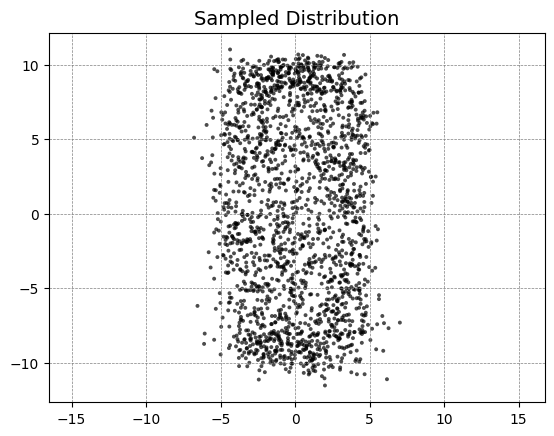

In [3]:
ode = GuidedVectorField(model1, guidance_scale=1, null_index=5)
solver = EulerODESolver(ode)
sampler = Sampler(solver)

steps = torch.linspace(0.01, 1, 2000).view(1, -1, 1).expand(2000, -1, 1).to(device)
gaussian_samples = gaussian_path.p_init.sample(2000)

condition_index = 4
y_index = torch.full((gaussian_samples.shape[0],), fill_value=condition_index, dtype=torch.long, device=device)

final_samples = sampler.sample_without_traj(gaussian_samples, steps, y_index = y_index)

plot_samples(final_samples)
plt.show()

Lets look at the diffusion case for guidance

In [4]:
GaussianMix = GaussianMixture.symmetric_2D(4,std = 1)

rec1 = RectangleDataset(device=device, coords= [(-5.0,5.0),(-10,10)])

dataset = union_sample([GaussianMix, rec1])

gaussian_path = GaussianConditionalProbabilityPath(p_data=dataset, alpha=LinearAlpha(), beta = SquareRootBeta(), device=device).to(device)

model1 = EmbeddedBasicMLP(input_dim=2, hidden_dims=[64,64,64,64], conditional=True, embedding_dim=40, num_conditions=6)

trainer = RecCenterGuidanceTrainer(path=gaussian_path, model=model1, num_conditions=6, p_uncond=0.1,model_type="Diffusion",rectangle_boundaries=[[(-5.0,5.0),(-10,10)]], centers=[torch.Tensor([10.0,0.0]), torch.Tensor([0.0,-10.0]), torch.Tensor([0.0,10.0]), torch.Tensor([-10.0,0.0])])

trainer.train_loop(num_epochs=15000, device=device, lr=1e-3, n= 2000)

In Epoch 0 we have a loss of 7.644071578979492
In Epoch 1000 we have a loss of 13.297186851501465
In Epoch 2000 we have a loss of 5.972487449645996
In Epoch 3000 we have a loss of 9.124713897705078
In Epoch 4000 we have a loss of 561.6875610351562
In Epoch 5000 we have a loss of 9.00430679321289
In Epoch 6000 we have a loss of 5.68798828125
In Epoch 7000 we have a loss of 8.247323036193848
In Epoch 8000 we have a loss of 11.800512313842773
In Epoch 9000 we have a loss of 6.787049293518066
In Epoch 10000 we have a loss of 10.583898544311523
In Epoch 11000 we have a loss of 5.927387237548828
In Epoch 12000 we have a loss of 30.92037582397461
In Epoch 13000 we have a loss of 6.864839553833008
In Epoch 14000 we have a loss of 6.246285915374756


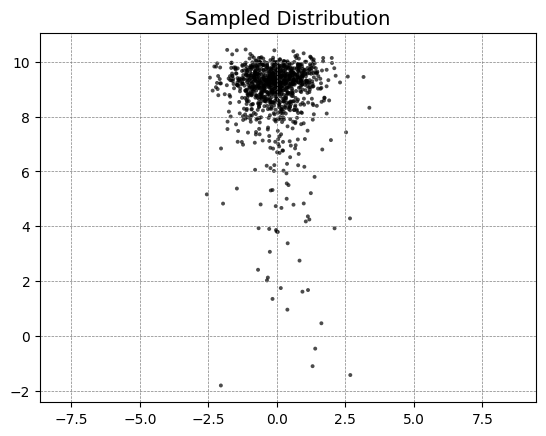

In [11]:
sde = ProductGuidanceLangevin([model1, model1], alpha=LinearAlpha(), beta=SquareRootBeta(), sigma=1.0, guidance_scales= [1.0,1.0], null_index=trainer.null_index)
sdesolver = EulerSDESolver(sde)
sdesampler = Sampler(sdesolver)

steps = torch.linspace(0.05, 1, 1000).view(1, -1, 1).expand(1000, -1, 1).to(device)
gaussian_samples = gaussian_path.p_init.sample(1000)



condition_index1 = 2
y_index1 = torch.full((gaussian_samples.shape[0],), fill_value=condition_index1, dtype=torch.long, device=device)

condition_index2 = 4
y_index2 = torch.full((gaussian_samples.shape[0],), fill_value=condition_index2, dtype=torch.long, device=device)

indicies = [y_index1, y_index2]

final_samples = sdesampler.sample_without_traj(gaussian_samples, steps, y_index = indicies)

plot_samples(final_samples)
plt.show()